In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My\Drive/HumorDetection

In [ ]:
!pip install transformers

In [4]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from tqdm.notebook import tqdm
import string
import re
import math
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, GRU, Conv1D, Dense, Input, Bidirectional, Dropout, SpatialDropout1D, MaxPooling1D, Flatten, BatchNormalization
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFBertModel, TFAlbertModel, TFRobertaModel, BertTokenizerFast, AlbertTokenizerFast, RobertaTokenizerFast
from sklearn.metrics import *
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

**Data preparation**

In [6]:
train_data = pd.read_csv('train.csv') 
dev_data = pd.read_csv('dev.csv')
test_data = pd.read_csv('test.csv')

In [7]:
def preprocess_text(text):
  """
  This function receives texts and returns clean word-list
  """
  # convert to lower case
  text = text.lower()
  # cleaning: non-ASCII filtering, appostrophes etc.
  text = re.sub(r"’", r"'", text)
  text = re.sub(r",", " ", text)
  text = re.sub(r"\.", " ", text)
  text = re.sub(r"!", " ", text)
  text = re.sub(r"\/", " ", text)
  text = re.sub(r"\^", " ", text)
  text = re.sub(r"\+", " ", text)
  text = re.sub(r"\*", "", text)
  text = re.sub(r"\-", " ", text)
  text = re.sub(r"\=", " ", text)
  text = re.sub(r":", " ", text)
  text = re.sub(r";", " ", text)
  text = re.sub(r"\"", " ", text)
  text = re.sub(r"“", " ", text)
  text = re.sub(r"\&", " ", text)
  text = re.sub(r"\?", " ", text)
  text = re.sub(r"\(", " ", text)
  text = re.sub(r"\)", " ", text)
  text = re.sub(r"-", " ", text)
  text = re.sub(r"”", " ", text)
  text = re.sub(r"%", " ", text)
  text = re.sub(r"‘", "'", text)
  text = re.sub(r"@", " ", text)
  text = re.sub(r"\$", " ", text)
  text = re.sub(r"–", " ", text)
  text = re.sub(r"£", " ", text)
  text = re.sub(r"{", " ", text)
  text = re.sub(r"}", " ", text)
  text = re.sub(r"・", " ", text)
  text = re.sub(r"\.{3}", " ", text)
  text = re.sub(r"„", " ", text)
  text = re.sub(r"\s{2,}", " ", text)

  tokenizer = TweetTokenizer()
  words = tokenizer.tokenize(text)

  contractions = {"aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
                  "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
                  "i'd": "i would", "i'll": "i will", "i'm": "i am", "isn't": "is not", "it's": "it is", "it'll": "it will",
                  "i've": "i have", "let's": "let us", "mightn't": "might not", "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
                  "she'll": "she will", "she's": "she is", "shouldn't": "should not", "that's": "that is", "there's": "there is", "they'd": "they would",
                  "they'll": "they will", "they're": "they are", "they've": "they have", "we'd": "we would", "we're": "we are", "weren't": "were not",
                  "we've": "we have", "what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have", "where's": "where is",
                  "who'd": "who would", "who'll": "who will", "who're": "who are", "who's": "who is", "who've": "who have", "won't": "will not",
                  "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have", "'re": " are",
                  "wasn't": "was not", "we'll": "we will"}
  words = [contractions[word] if word in contractions else word for word in words]

  clean_text = " ".join(words)
  clean_text = re.sub("  ", " ", clean_text)
  return clean_text

In [8]:
def calculate_metrics_classification(y_test, y_predicted):
  print(classification_report(y_test, y_predicted))
  plt.figure(figsize=(7,7))
  sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, fmt='.5g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion matrix')
  plt.show()

In [9]:
def load_embeddings(file_name, vocabulary):
  """
  Loads word embeddings from the file with the given name.
  :param file_name: name of the file containing word embeddings
  :type file_name: str
  :param vocabulary: captions vocabulary
  :type vocabulary: numpy.array
  :return: word embeddings
  :rtype: dict
  """
  embeddings = dict()
  with open(file_name, 'r', encoding='utf-8') as doc:
    line = doc.readline()
    while line != '':
      line = line.rstrip('\n').lower()
      parts = line.split(' ')
      vals = np.array(parts[1:], dtype=np.float)
      if parts[0] in vocabulary:
        embeddings[parts[0]] = vals
      line = doc.readline()
  return embeddings

In [10]:
def load_embedding_weights(vocabulary, embedding_size):
  """
  Creates and loads embedding weights.
  :param vocabulary: captions vocabulary
  :type vocabulary: numpy.array
  :param embedding_size: embedding size
  :type embedding_size: int
  :return: embedding weights
  :rtype: numpy.array
  """
  if os.path.exists('embedding_matrix.pkl'):
    with open('embedding_matrix.pkl', 'rb') as f:
      embedding_matrix = pickle.load(f)
  else:
    print('Creating embedding weights...')
    embeddings = load_embeddings(f'glove.twitter.27B.{embedding_size}d.txt', vocabulary)
    embedding_matrix = np.zeros((len(vocabulary), embedding_size))
    for i in range(len(vocabulary)):
      if vocabulary[i] in embeddings.keys():
        embedding_matrix[i] = embeddings[vocabulary[i]]
      else:
        embedding_matrix[i] = np.random.standard_normal(embedding_size)
    with open('embedding_matrix.pkl', 'wb') as f:
      pickle.dump(embedding_matrix, f)
  return embedding_matrix

In [11]:
train_data['text'] = train_data['text'].apply(lambda x: preprocess_text(x))
dev_data['text'] = dev_data['text'].apply(lambda x: preprocess_text(x))
test_data['text'] = test_data['text'].apply(lambda x: preprocess_text(x))

In [12]:
train_data = train_data.dropna()
dev_data = dev_data.dropna()
test_data = test_data.dropna()
train_data.humor_controversy = train_data.humor_controversy.astype(int)
dev_data.humor_controversy = dev_data.humor_controversy.astype(int)
test_data.humor_controversy = test_data.humor_controversy.astype(int)

In [13]:
X_train = train_data['text']
y_train = train_data['humor_controversy']
count = sum([len(i.split()) for i in X_train])
avg_length = math.ceil(count/len(X_train))
print("Average length of all the texts is:", avg_length)
X_dev = dev_data['text']
y_dev = dev_data['humor_controversy']
X_test = test_data['text']
y_test = test_data['humor_controversy']

Average length of all the texts is: 22


In [14]:
X = X_train
X = X.append(X_dev, ignore_index=True)
X = X.append(X_test, ignore_index=True)
y_train = np.array(y_train)
y_train = y_train.reshape(-1, 1)
y_dev = np.array(y_dev)
y_dev = y_dev.reshape(-1, 1)
y_test = np.array(y_test)
y_test = y_test.reshape(-1, 1)

In [15]:
# Setting tokenizer properties
vocabulary_size = 20000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
# Setting the padding properties
max_length = 50
trunc_type = 'post'
padding_type = 'post'
# Creating padded sequences from train and test data
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(X_dev)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
all_sequences = tokenizer.texts_to_sequences(X)
all_padded = pad_sequences(all_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [16]:
vocabulary = list(word_index.keys())
vocabulary.insert(0, '<tok>')
vocabulary_size = len(vocabulary)

In [17]:
# Converting the lists to numpy arrays for Tensorflow 2.x
training_padded = np.array(training_padded)
validation_padded = np.array(validation_padded)
testing_padded = np.array(testing_padded)

In [18]:
embedding_weights = load_embedding_weights(vocabulary, 100)
embedding_dim = 100

Creating embedding weights...


In [19]:
# Model with Embedding layer without initialized weights
def build_LSTM1(vocabulary_size, max_len):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len))
  model.add(Dropout(0.3))
  model.add(LSTM(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [20]:
# Model with Embedding layer with initialized weights (without training)
def build_LSTM2(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=False))
  model.add(Dropout(0.3))
  model.add(LSTM(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [21]:
# Model with Embedding layer with initialized weights (with training)
def build_LSTM3(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(Dropout(0.3))
  model.add(LSTM(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [22]:
# Model with Embedding layer without initialized weights
def build_GRU1(vocabulary_size, max_len):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len))
  model.add(Dropout(0.3))
  model.add(GRU(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [23]:
# Model with Embedding layer with initialized weights (without training)
def build_GRU2(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=False))
  model.add(Dropout(0.3))
  model.add(GRU(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [24]:
# Model with Embedding layer with initialized weights (with training)
def build_GRU3(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(Dropout(0.3))
  model.add(GRU(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [25]:
def build_bidirectional_LSTM(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(SpatialDropout1D(0.3))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(32, return_sequences=True)))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [26]:
def build_bidirectional_GRU(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(SpatialDropout1D(0.3))
  model.add(Dropout(0.3))
  model.add(Bidirectional(GRU(32, return_sequences=True)))
  model.add(Bidirectional(GRU(32)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [27]:
def build_CNN(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(Conv1D(32, kernel_size=5, activation="relu"))
  model.add(Dropout(0.3))
  model.add(Conv1D(16, kernel_size=3, activation="sigmoid"))
  model.add(MaxPooling1D(pool_size=3))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [28]:
def build_LSTM_CNN(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.0)))
  model.add(Conv1D(64, kernel_size=3, activation='relu', padding='valid', kernel_initializer='he_uniform'))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [29]:
def build_CNN_LSTM(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(SpatialDropout1D(0.4))
  model.add(Conv1D(64, kernel_size=4, activation='relu', padding='valid', kernel_initializer='he_uniform'))
  model.add(MaxPooling1D(pool_size=4))
  model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.0)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [30]:
def plot_graph_loss(history):
  # Evaluating Accuracy and Loss of the model
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(accuracy)) # Number of epochs

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

**LSTM Model 1**

In [31]:
lstm_model1 = build_LSTM1(vocabulary_size, max_length)
history = lstm_model1.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1144800   
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,161,857
Trainable params: 1,161,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
155/155 [==============================] - 10s 18ms/step - loss: 0.6943 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 2/10
155/155 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.5059

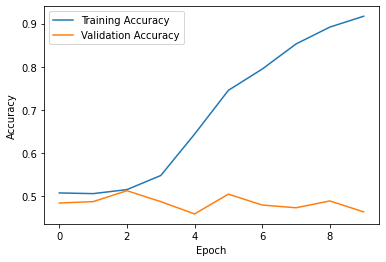

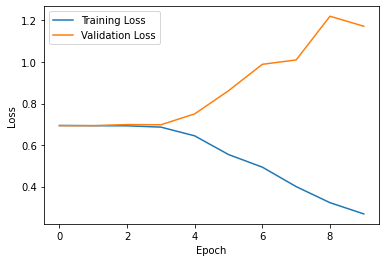

In [32]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.56      0.57      0.57       336
           1       0.47      0.46      0.47       279

    accuracy                           0.52       615
   macro avg       0.52      0.52      0.52       615
weighted avg       0.52      0.52      0.52       615



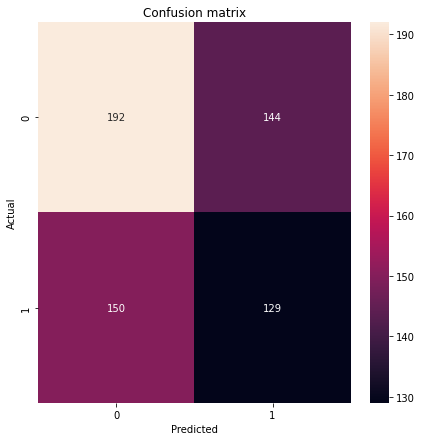

In [33]:
predictions = lstm_model1.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**LSTM Model 2**

In [34]:
lstm_model2 = build_LSTM2(vocabulary_size, max_length, embedding_weights)
history = lstm_model2.fit(training_padded, y_train, epochs=100, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1144800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,161,857
Trainable params: 17,057
Non-trainable params: 1,144,800
_________________________________________________________________
Epoch 1/100
155/155 [==============================] - 4s 15ms/step - loss: 0.7004 - accuracy: 0.4915 - val_loss: 0.6959 - val_accuracy: 0.4889
Epoch 2/100
155/155 [==============================] - 2s 12ms/step - loss: 0.6963 - accuracy

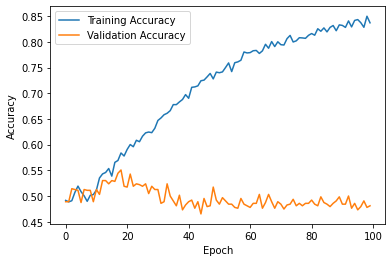

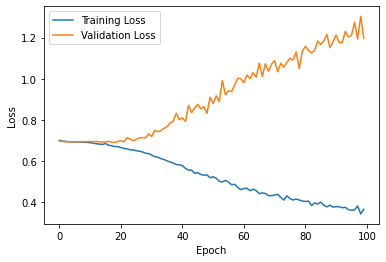

In [35]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.57      0.63      0.60       336
           1       0.49      0.43      0.46       279

    accuracy                           0.54       615
   macro avg       0.53      0.53      0.53       615
weighted avg       0.53      0.54      0.53       615



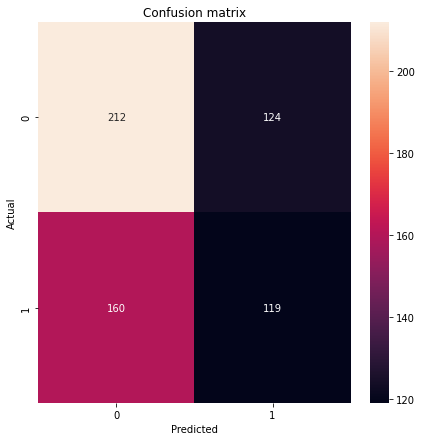

In [36]:
predictions = lstm_model2.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**LSTM Model 3**

In [37]:
lstm_model3 = build_LSTM3(vocabulary_size, max_length, embedding_weights)
history = lstm_model3.fit(training_padded, y_train, epochs=20, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1144800   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,161,857
Trainable params: 1,161,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
155/155 [==============================] - 5s 17ms/step - loss: 0.6975 - accuracy: 0.5047 - val_loss: 0.6927 - val_accuracy: 0.5142
Epoch 2/20
155/155 [==============================] - 2s 14ms/step - loss: 0.6941 - accuracy: 0.508

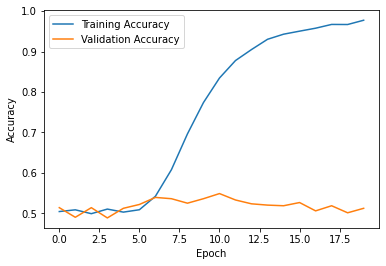

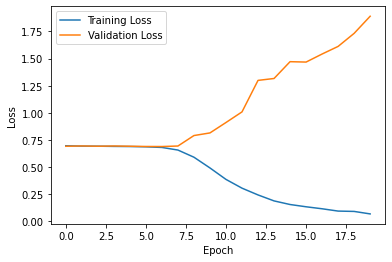

In [38]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.55      0.53      0.54       336
           1       0.46      0.48      0.47       279

    accuracy                           0.51       615
   macro avg       0.50      0.50      0.50       615
weighted avg       0.51      0.51      0.51       615



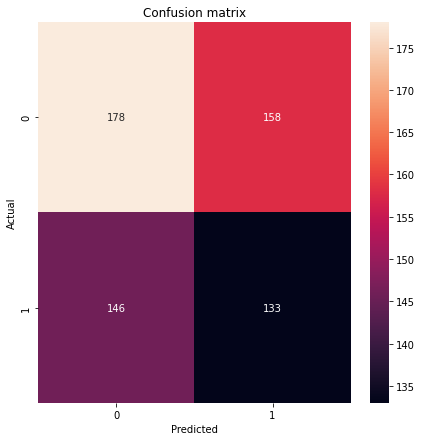

In [39]:
predictions = lstm_model3.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**GRU Model 1**

In [40]:
gru_model1 = build_GRU1(vocabulary_size, max_length)
history = gru_model1.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1144800   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,157,697
Trainable params: 1,157,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
155/155 [==============================] - 5s 17ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5142
Epoch 2/10
155/155 [==============================] - 2s 14ms/step - loss: 0.6933 - accuracy: 0.498

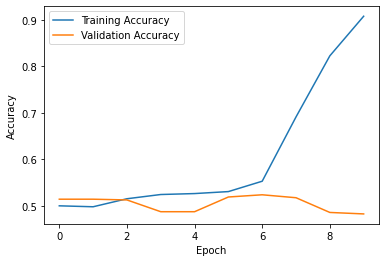

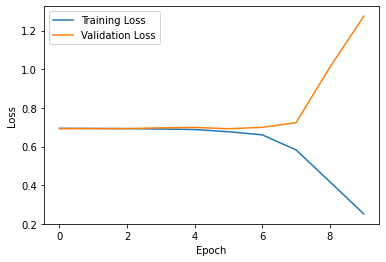

In [41]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.56      0.56      0.56       336
           1       0.47      0.46      0.46       279

    accuracy                           0.52       615
   macro avg       0.51      0.51      0.51       615
weighted avg       0.52      0.52      0.52       615



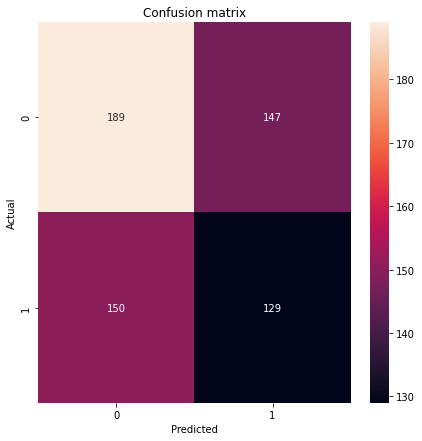

In [42]:
predictions = gru_model1.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**GRU Model 2**

In [43]:
gru_model2 = build_GRU2(vocabulary_size, max_length, embedding_weights)
history = gru_model2.fit(training_padded, y_train, epochs=100, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1144800   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,157,697
Trainable params: 12,897
Non-trainable params: 1,144,800
_________________________________________________________________
Epoch 1/100
155/155 [==============================] - 5s 15ms/step - loss: 0.7027 - accuracy: 0.5016 - val_loss: 0.6929 - val_accuracy: 0.5174
Epoch 2/100
155/155 [==============================] - 2s 11ms/step - loss: 0.6978 - accuracy

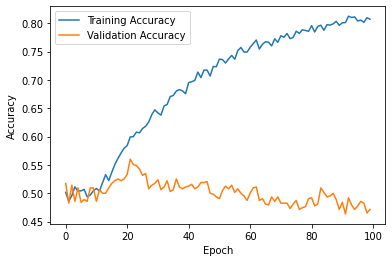

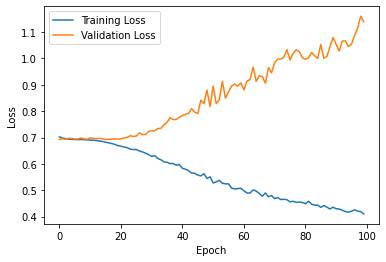

In [44]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.54      0.53      0.53       336
           1       0.44      0.46      0.45       279

    accuracy                           0.49       615
   macro avg       0.49      0.49      0.49       615
weighted avg       0.50      0.49      0.49       615



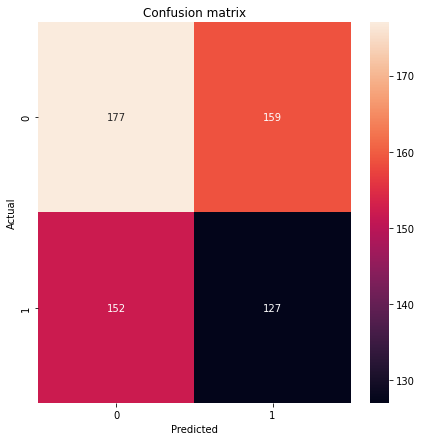

In [45]:
predictions = gru_model2.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**GRU Model 3**

In [46]:
gru_model3 = build_GRU3(vocabulary_size, max_length, embedding_weights)
history = gru_model3.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           1144800   
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,157,697
Trainable params: 1,157,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
155/155 [==============================] - 5s 17ms/step - loss: 0.7065 - accuracy: 0.5032 - val_loss: 0.6927 - val_accuracy: 0.5411
Epoch 2/10
155/155 [==============================] - 2s 14ms/step - loss: 0.6993 - accuracy: 0.494

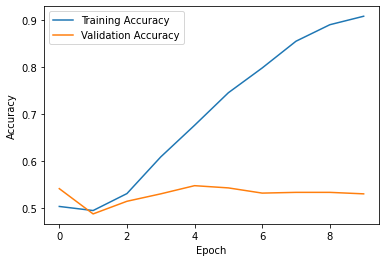

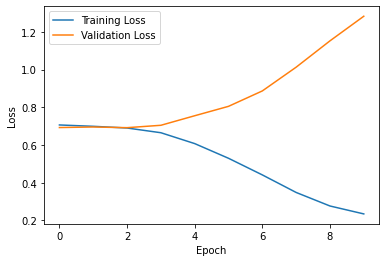

In [47]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.58      0.45      0.51       336
           1       0.48      0.60      0.53       279

    accuracy                           0.52       615
   macro avg       0.53      0.53      0.52       615
weighted avg       0.53      0.52      0.52       615



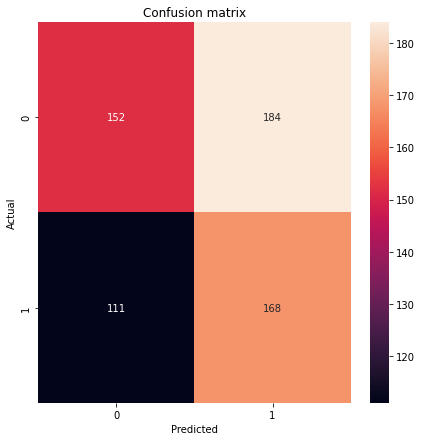

In [48]:
predictions = gru_model3.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**Bidirectional LSTM**

In [55]:
bi_lstm = build_bidirectional_LSTM(vocabulary_size, max_length, embedding_weights)
history = bi_lstm.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 100)           1144800   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 64)            34048     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,203,745
Trainable params: 1,203,745
Non-trainable params: 0
____________________________________________

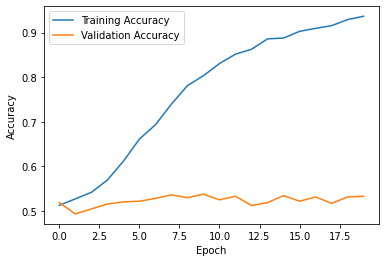

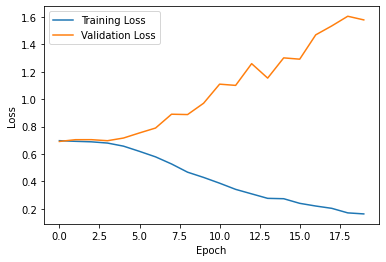

In [56]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.54      0.49      0.51       336
           1       0.45      0.50      0.47       279

    accuracy                           0.49       615
   macro avg       0.49      0.49      0.49       615
weighted avg       0.50      0.49      0.49       615



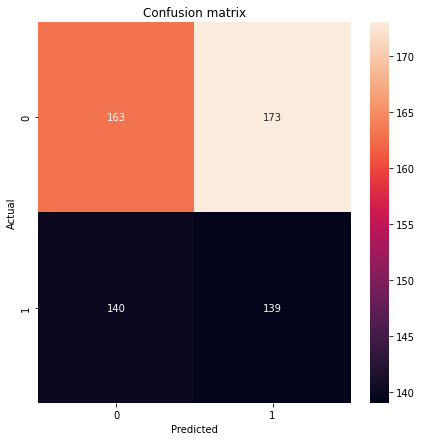

In [57]:
predictions = bi_lstm.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**Bidirectional GRU**

In [52]:
bi_gru = build_bidirectional_GRU(vocabulary_size, max_length, embedding_weights)
history = bi_gru.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           1144800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 64)            25728     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,189,409
Trainable params: 1,189,409
Non-trainable params: 0
____________________________________________

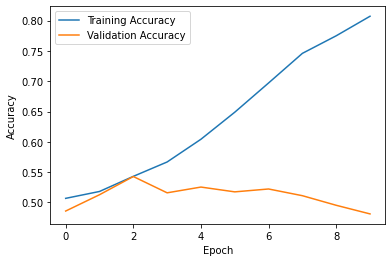

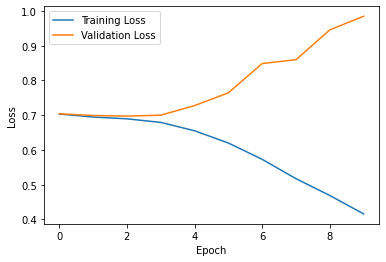

In [53]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.55      0.51      0.53       336
           1       0.45      0.49      0.47       279

    accuracy                           0.50       615
   macro avg       0.50      0.50      0.50       615
weighted avg       0.50      0.50      0.50       615



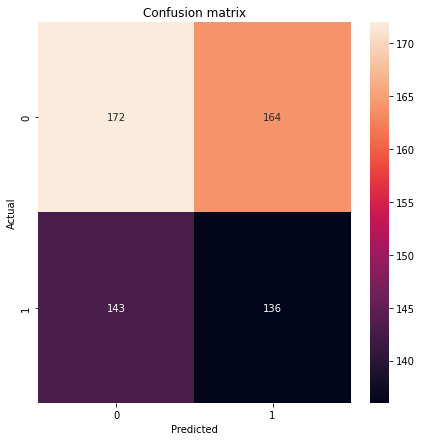

In [54]:
predictions = bi_gru.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**CNN Model**

In [58]:
cnn = build_CNN(vocabulary_size, max_length, embedding_weights)
history = cnn.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           1144800   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 32)            16032     
_________________________________________________________________
dropout_9 (Dropout)          (None, 46, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 16)            1552      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

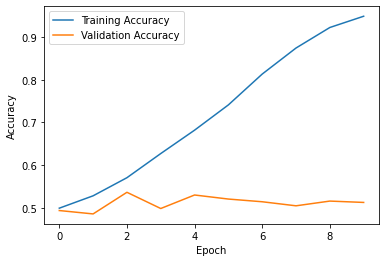

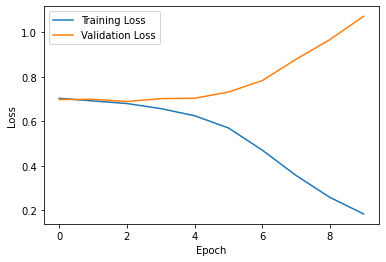

In [59]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.55      0.48      0.51       336
           1       0.46      0.53      0.49       279

    accuracy                           0.50       615
   macro avg       0.50      0.50      0.50       615
weighted avg       0.51      0.50      0.50       615



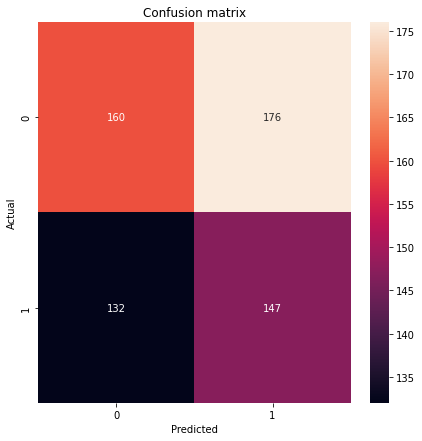

In [60]:
predictions = cnn.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**LSTM CNN Model**

In [61]:
lstm_cnn = build_LSTM_CNN(vocabulary_size, max_length, embedding_weights)
history = lstm_cnn.fit(training_padded, y_train, epochs=20, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 100)           1144800   
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 64)            24640     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 3073      
Total params: 1,256,993
Trainable params: 1,256,993
Non-trainable params: 0
___________________________________________

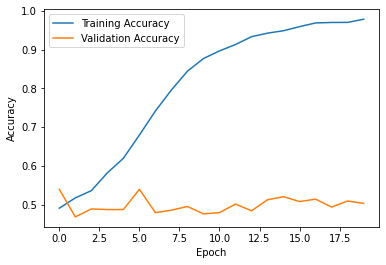

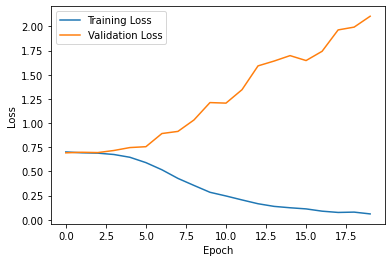

In [62]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.58      0.47      0.52       336
           1       0.48      0.58      0.53       279

    accuracy                           0.52       615
   macro avg       0.53      0.53      0.52       615
weighted avg       0.53      0.52      0.52       615



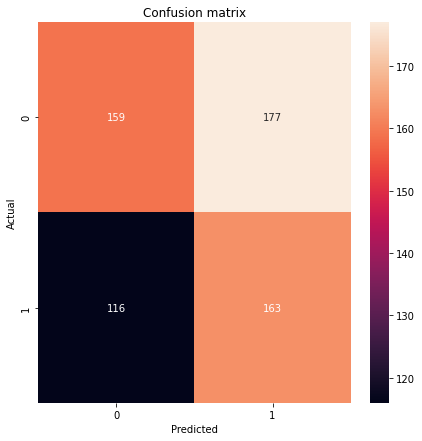

In [63]:
predictions = lstm_cnn.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**CNN LSTM Model**

In [64]:
cnn_lstm = build_CNN_LSTM(vocabulary_size, max_length, embedding_weights)
history = cnn_lstm.fit(training_padded, y_train, epochs=20, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 100)           1144800   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 47, 64)            25664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 1,195,361
Trainable params: 1,195,361
Non-trainable params: 0
___________________________________________

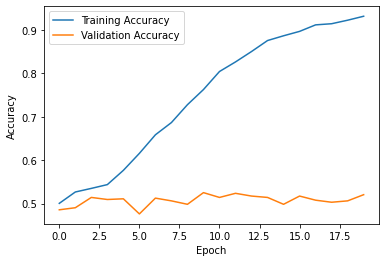

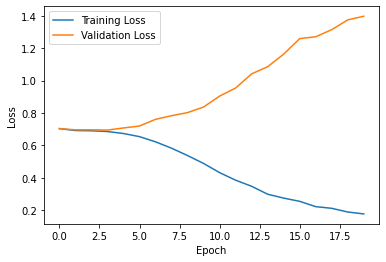

In [65]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       336
           1       0.43      0.45      0.44       279

    accuracy                           0.48       615
   macro avg       0.48      0.48      0.48       615
weighted avg       0.48      0.48      0.48       615



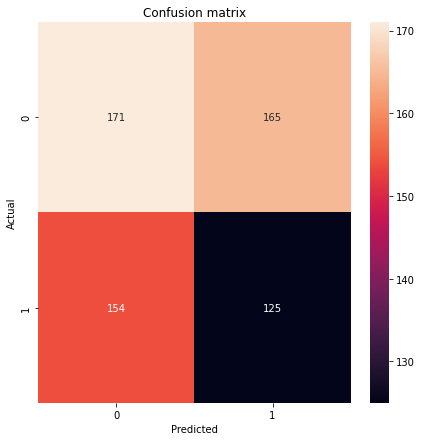

In [66]:
predictions = cnn_lstm.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**BERT Model**

In [115]:
text_train = list(X_train)
text_val = list(X_dev)
text_test = list(X_test)

In [116]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [117]:
train_encodings = bert_tokenizer(text_train, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
val_encodings = bert_tokenizer(text_val, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
test_encodings = bert_tokenizer(text_test, max_length=100, truncation=True, padding="max_length", return_tensors='tf')

In [118]:
def bert_model(input_shape):
    model = TFBertModel.from_pretrained('bert-base-uncased')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dropout(0.3)(pooled_output)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [119]:
model = bert_model((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics=metric)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_9 (Sli (None, 768)          0           bert[0][0]                 

In [120]:
history = model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_dev),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
309/309 [==============================] - 234s 690ms/step - loss: 0.6999 - binary_accuracy: 0.5128 - precision_9: 0.5111 - recall_9: 0.5801 - val_loss: 0.6917 - val_binary_accuracy: 0.5380 - val_precision_9: 0.5444 - val_recall_9: 0.3182
Epoch 2/3
309/309 [==============================] - 209s 676ms/step - loss: 0.6885 - binary_accuracy: 0.5562 - precision_9: 0.5551 - recall_9: 0.5643 - val_loss: 0.7265 - val_binary_accuracy: 0.5047 - val_precision_9: 0.4957 - val_recall_9: 0.9416
Epoch 3/3
309/309 [==============================] - 209s 676ms/step - loss: 0.6714 - binary_accuracy: 0.5829 - precision_9: 0.5765 - recall_9: 0.6235 - val_loss: 0.6903 - val_binary_accuracy: 0.5570 - val_precision_9: 0.5405 - val_recall_9: 0.6071


              precision    recall  f1-score   support

           0       0.60      0.53      0.56       336
           1       0.50      0.57      0.53       279

    accuracy                           0.55       615
   macro avg       0.55      0.55      0.55       615
weighted avg       0.55      0.55      0.55       615



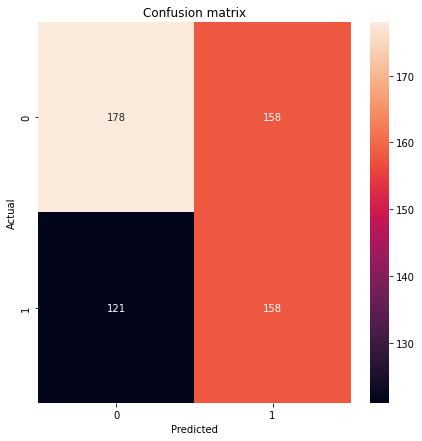

In [121]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

**ALBERT Model**

In [78]:
albert_tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [94]:
train_encodings = albert_tokenizer(text_train, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
val_encodings = albert_tokenizer(text_val, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
test_encodings = albert_tokenizer(text_test, max_length=100, truncation=True, padding="max_length", return_tensors='tf')

In [95]:
def albert_model(input_shape):
    model = TFAlbertModel.from_pretrained('albert-base-v2')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dropout(0.3)(pooled_output)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [96]:
model = albert_model((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics=metric)
model.summary()

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
albert (TFAlbertMainLayer)      TFBaseModelOutputWit 11683584    input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 768)          0           albert[0][0]               

In [97]:
history = model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_dev),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
309/309 [==============================] - 221s 660ms/step - loss: 0.7153 - binary_accuracy: 0.5024 - precision_5: 0.5024 - recall_5: 0.4755 - val_loss: 0.6929 - val_binary_accuracy: 0.5127 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/3
309/309 [==============================] - 200s 648ms/step - loss: 0.6986 - binary_accuracy: 0.5063 - precision_5: 0.5059 - recall_5: 0.5181 - val_loss: 0.6950 - val_binary_accuracy: 0.4873 - val_precision_5: 0.4873 - val_recall_5: 1.0000
Epoch 3/3
309/309 [==============================] - 200s 646ms/step - loss: 0.6961 - binary_accuracy: 0.5030 - precision_5: 0.5029 - recall_5: 0.4905 - val_loss: 0.6906 - val_binary_accuracy: 0.5237 - val_precision_5: 0.5075 - val_recall_5: 0.7727


              precision    recall  f1-score   support

           0       0.63      0.20      0.31       336
           1       0.47      0.86      0.61       279

    accuracy                           0.50       615
   macro avg       0.55      0.53      0.46       615
weighted avg       0.56      0.50      0.44       615



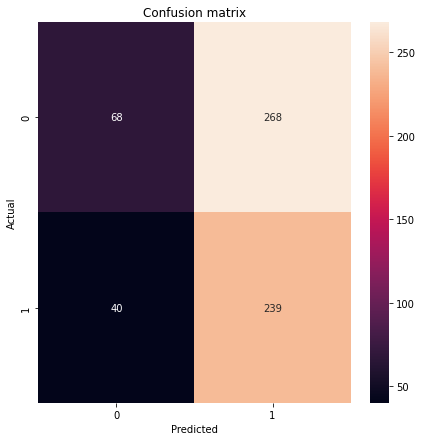

In [98]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

**RoBERTa Model**

In [103]:
roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [104]:
train_encodings = roberta_tokenizer(text_train, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
val_encodings = roberta_tokenizer(text_val, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
test_encodings = roberta_tokenizer(text_test, max_length=100, truncation=True, padding="max_length", return_tensors='tf')

In [105]:
def roberta_model(input_shape):
    model = TFRobertaModel.from_pretrained('roberta-base')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dropout(0.3)(pooled_output)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [106]:
model = roberta_model((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics=metric)
model.summary()

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
roberta (TFRobertaMainLayer)    TFBaseModelOutputWit 124645632   input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None, 768)          0           roberta[0][0]              

In [107]:
history = model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_dev),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
309/309 [==============================] - 237s 703ms/step - loss: 0.6976 - binary_accuracy: 0.5047 - precision_7: 0.5047 - recall_7: 0.4803 - val_loss: 0.6927 - val_binary_accuracy: 0.4858 - val_precision_7: 0.4864 - val_recall_7: 0.9870
Epoch 2/3
309/309 [==============================] - 213s 688ms/step - loss: 0.6927 - binary_accuracy: 0.5333 - precision_7: 0.5343 - recall_7: 0.5148 - val_loss: 0.6898 - val_binary_accuracy: 0.5380 - val_precision_7: 0.5174 - val_recall_7: 0.7727
Epoch 3/3
309/309 [==============================] - 213s 688ms/step - loss: 0.6838 - binary_accuracy: 0.5649 - precision_7: 0.5692 - recall_7: 0.5323 - val_loss: 0.6835 - val_binary_accuracy: 0.5649 - val_precision_7: 0.5609 - val_recall_7: 0.4935


              precision    recall  f1-score   support

           0       0.57      0.61      0.59       336
           1       0.48      0.44      0.46       279

    accuracy                           0.53       615
   macro avg       0.53      0.53      0.52       615
weighted avg       0.53      0.53      0.53       615



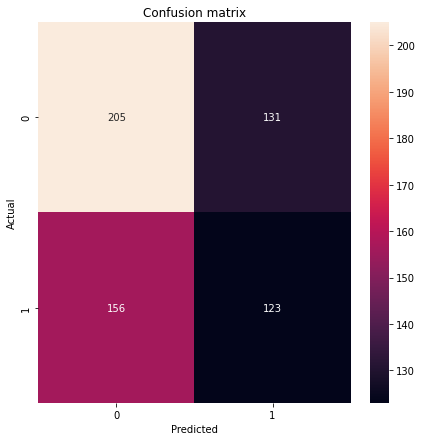

In [108]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)